## Set up

Download the dataset from: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

In [1]:
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp /content/Water_Bodies_Dataset.zip /content/drive/MyDrive/Water_Bodies_Dataset.zip
#!cp /content/drive/MyDrive/Water_Bodies_Dataset.zip ./

In [11]:
! unzip Water_Bodies_Dataset.zip &> /dev/null

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [2]:
points = {}
ground_truth_masks = {}

for f in sorted(Path('/content/Water Bodies Dataset/Masks/').iterdir()):
    k = f.suffix
    if k == ".jpg":
        im = cv2.imread(f.as_posix())
        gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        # contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
        ground_truth_masks[f.stem] = thresh1
        # if len(contours) > 1:
            # x,y,w,h = cv2.boundingRect(contours[0])
            # height, width, _ = im.shape
            # bbox_coords[f.stem] = np.array([x, y, x + w, y + h])

        if len(thresh1[thresh1 == 255]) > 10:
            points[f.stem] = thresh1 == 255

In [3]:
points['water_body_2']

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [4]:
len(ground_truth_masks['water_body_2'][ground_truth_masks['water_body_2']==255])

163289

In [5]:
len(ground_truth_masks['water_body_2'][ground_truth_masks['water_body_2']==0])

663899

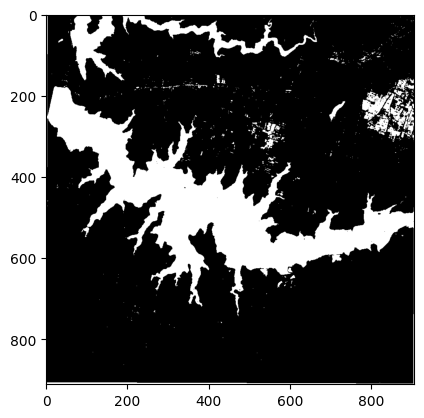

In [6]:
plt.imshow(ground_truth_masks['water_body_2'], cmap="gray")

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [7]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
  
# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

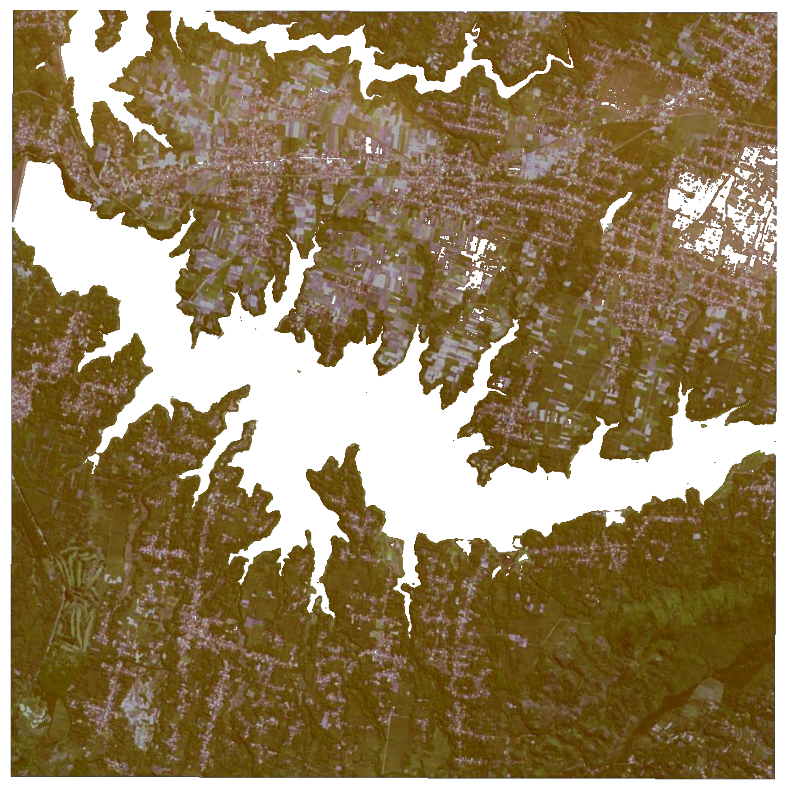

In [8]:
name = 'water_body_2'
image = cv2.imread(f'/content/Water Bodies Dataset/Images/{name}.jpg')

plt.figure(figsize=(10,10))
plt.imshow(image)
# show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [9]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [96]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

We convert the input images into a format SAM's internal functions expect.

In [97]:
import numpy as np

def select_points(matrix, num_points):
    # Get the indices of the non-zero elements
    nonzero_indices = np.transpose(np.nonzero(matrix))

    # Check if the number of non-zero elements is less than the desired number of points
    if len(nonzero_indices) < num_points:
        raise ValueError("The number of non-zero elements in the matrix is less than the desired number of points.")

    # Randomly select the indices of the points
    selected_indices = np.random.choice(len(nonzero_indices), size=num_points, replace=False)

    # Get the row and column indices corresponding to the selected indices
    row_indices, col_indices = nonzero_indices[selected_indices].T

    # Return the locations of the selected points
    return torch.tensor(np.array(list(zip(row_indices, col_indices)))), torch.tensor(np.array([1 for i in range(num_points)]))

In [98]:
selected_points = select_points(points["water_body_2"], num_points=10)
print(selected_points)

(tensor([[501, 337],
        [599, 331],
        [692, 471],
        [485, 404],
        [340, 199],
        [293, 550],
        [ 21, 244],
        [ 56, 426],
        [496, 333],
        [524, 801]]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))


In [106]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide
selected_points = []

transformed_data = defaultdict(dict)
for k in range(10):
    image = cv2.imread(f'/content/Water Bodies Dataset/Images/water_body_{k+1}.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[k]['image'] = input_image
    transformed_data[k]['input_size'] = input_size
    transformed_data[k]['original_image_size'] = original_image_size
    selected_points.append(select_points(points[f"water_body_{k+1}"], num_points=20))

In [107]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
# keys = list(bbox_coords.keys())

## Run fine tuning

This is the main training loop. 

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [114]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in range(10):
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']
    
    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)
      
      prompt_points = selected_points[k]
    #   box = transform.apply_boxes(prompt_box, original_image_size)
    #   box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    #   box_torch = box_torch[None, :]
      
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=prompt_points,
          boxes=None,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[f"water_body_{k+1}"], (1, 1, ground_truth_masks[f"water_body_{k+1}"].shape[0], ground_truth_masks[f"water_body_{k+1}"].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
    
    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

RuntimeError: ignored

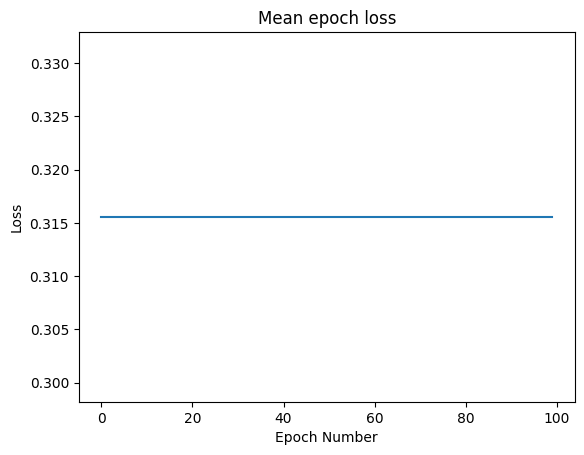

In [109]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [110]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [111]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [112]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = 2
image = cv2.imread(f'/content/Water Bodies Dataset/Images/water_body_{k}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

# input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=None,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=None,
    multimask_output=False,
)

We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

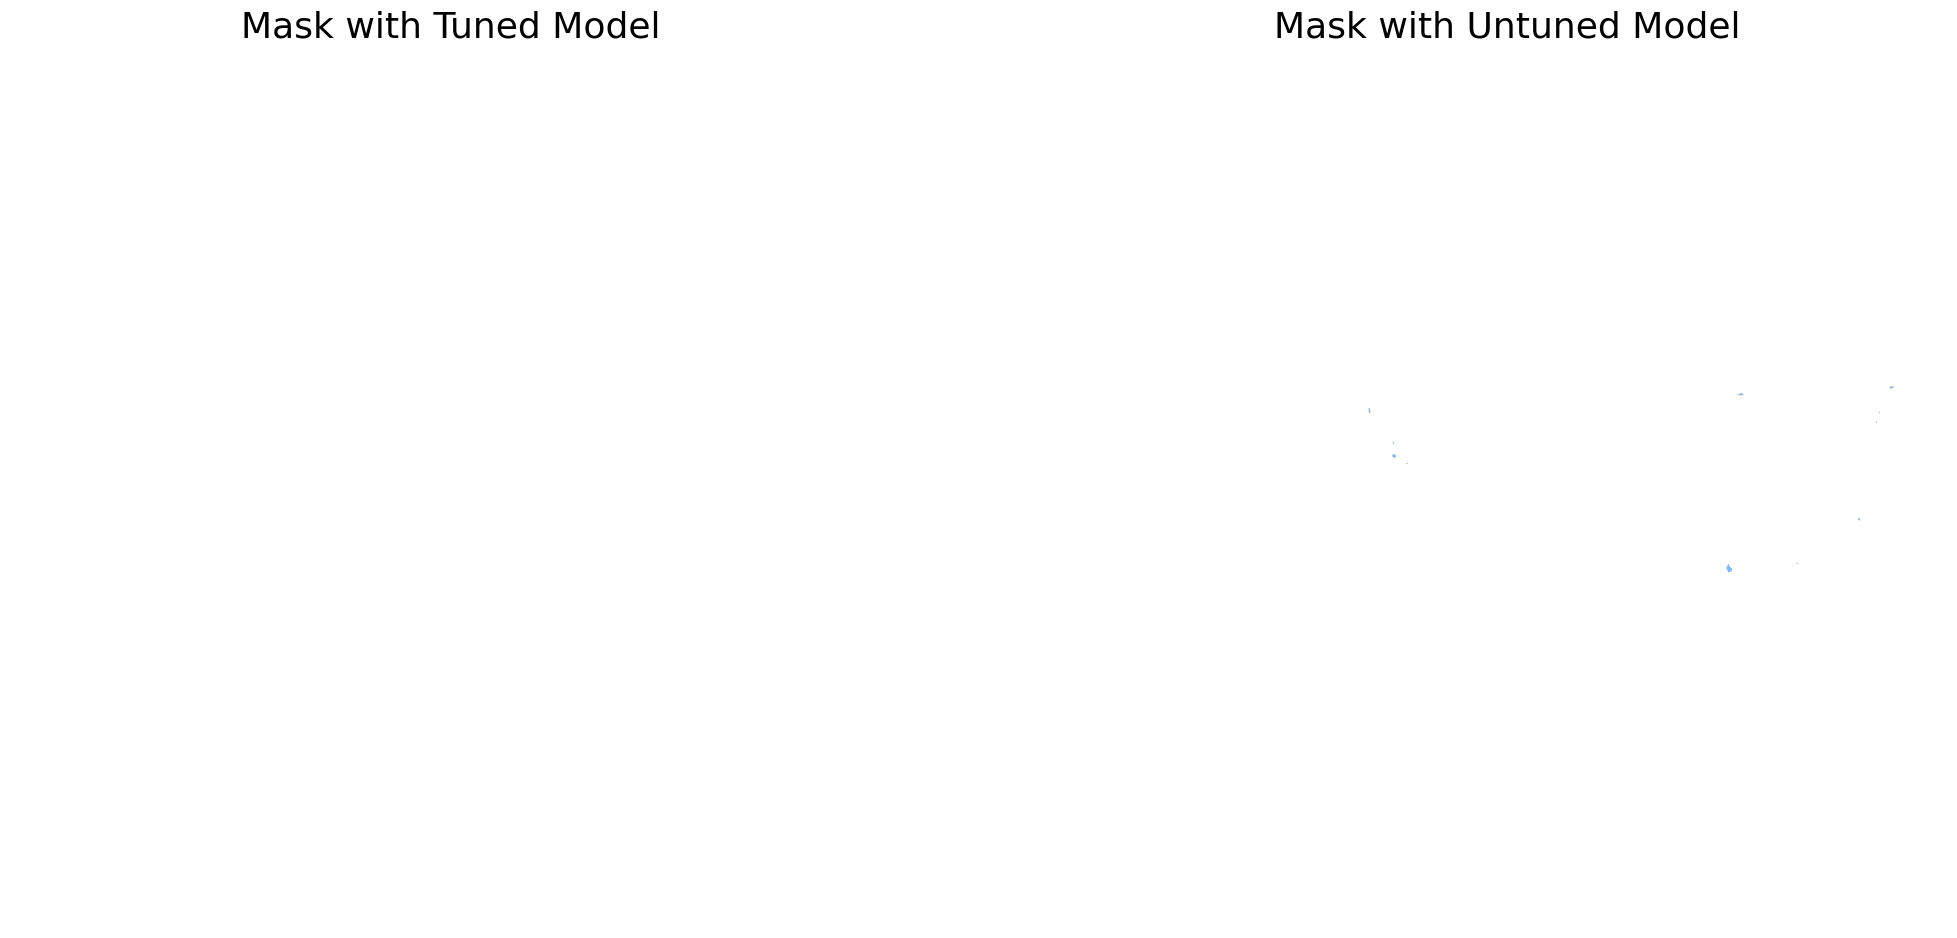

In [113]:
%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))


# axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
# show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


# axs[1].imshow(image)
show_mask(masks_orig, axs[1])
# show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  